In [1]:
%matplotlib notebook
import os
import config
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from validclust.indices import dunn
from itertools import cycle
from sklearn import metrics
from collections import OrderedDict
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS
from sklearn.model_selection import train_test_split, GridSearchCV
sns.set_style('white')

In [2]:
LOG_DIR = config.LOG_DIR
os.makedirs(f'{LOG_DIR}/figures', exist_ok=True)
os.makedirs(f'{LOG_DIR}/tables', exist_ok=True)

In [3]:
# Load loss, positive similarity and negative similarity
loss = pd.read_csv(f'{LOG_DIR}/loss.data', header=None)
positive_sim  = pd.read_csv(f'{LOG_DIR}/positive_similarity.data', header=None)
negative_sim  = pd.read_csv(f'{LOG_DIR}/negative_similarity.data', header=None)

In [4]:
validation_loss = loss.iloc[0, 1:]
train_loss = loss.iloc[1, 1:]

validation_positive_sim = positive_sim.iloc[0, 1:]
train_positive_sim = positive_sim.iloc[1, 1:]

validation_negative_sim = negative_sim.iloc[0, 1:]
train_negative_sim = negative_sim.iloc[1, 1:]

<IPython.core.display.Javascript object>


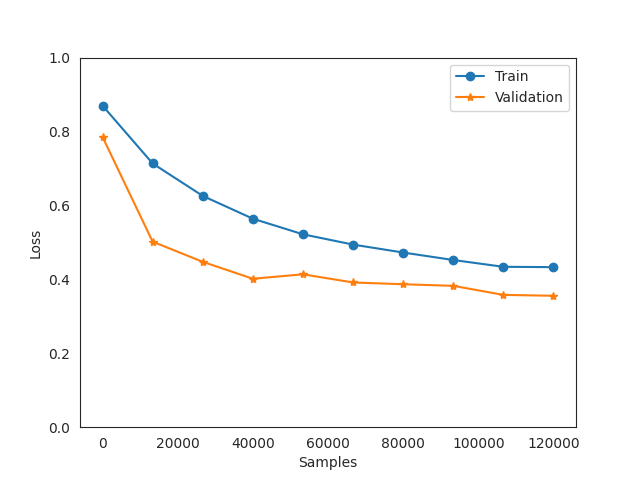

In [5]:
x = np.linspace(1, len(train_loss) * config.NUM_BATCHES_UNTIL_EVAL * config.BATCH_SIZE, len(train_loss))
plt.figure()
plt.plot(x, train_loss, marker='o', label=f'Train')
plt.plot(x, validation_loss, marker='*', label=f'Validation')
plt.xlabel('Samples')
plt.ylabel(f"Loss")
plt.ylim([0, 1])
plt.legend()
plt.savefig(f'{LOG_DIR}/loss.pdf')

<IPython.core.display.Javascript object>


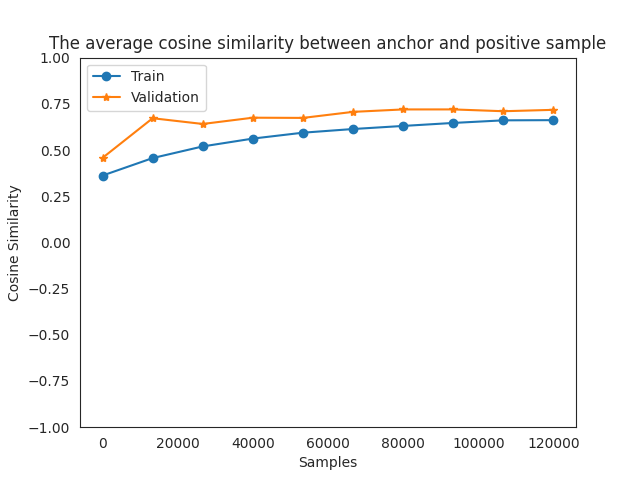

In [6]:
x = np.linspace(1, len(train_positive_sim) * config.NUM_BATCHES_UNTIL_EVAL * config.BATCH_SIZE, len(train_positive_sim))
plt.figure()
plt.plot(x, train_positive_sim, marker='o', label=f'Train')
plt.plot(x, validation_positive_sim, marker='*', label=f'Validation')
plt.title(f"The average cosine similarity between anchor and positive sample")
plt.xlabel('Samples')
plt.ylabel(f"Cosine Similarity")
plt.ylim([-1, 1])
plt.legend()
plt.savefig(f'{LOG_DIR}/positive_similarity.pdf')

<IPython.core.display.Javascript object>


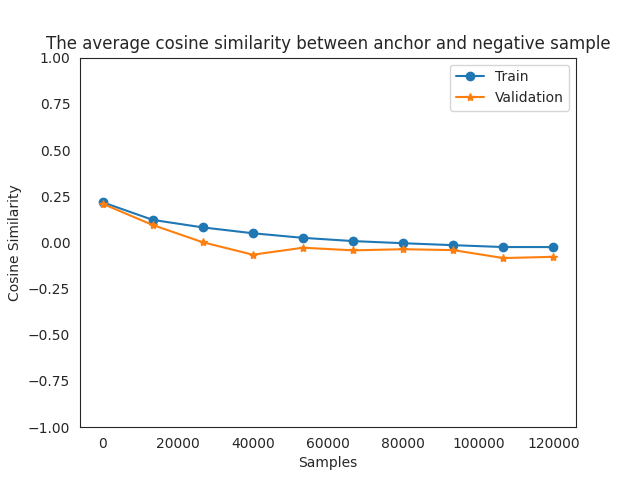

In [7]:
x = np.linspace(1, len(train_negative_sim) * config.NUM_BATCHES_UNTIL_EVAL * config.BATCH_SIZE, len(train_negative_sim))
plt.figure()
plt.plot(x, train_negative_sim, marker='o', label=f'Train')
plt.plot(x, validation_negative_sim, marker='*', label=f'Validation')
plt.title(f"The average cosine similarity between anchor and negative sample")
plt.xlabel('Samples')
plt.ylabel(f"Cosine Similarity")
plt.ylim([-1, 1])
plt.legend()
plt.savefig(f'{LOG_DIR}/negative_similarity.pdf')

## Load extracted features

In [8]:
df = pd.read_json(f'{LOG_DIR}/features.json', lines=True)
embedding_dim = np.shape(df.features.values[0])[0]
# Expand features into columns
df_features = pd.DataFrame([feat for feat in df.features.values])

df = df_features.assign(method_name=df.method_name)
df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,method_name
0,-0.228556,-0.130616,0.079007,-0.419809,-0.811307,0.585606,-0.506203,0.995348,1.405312,0.211671,...,1.350299,1.463132,-0.598353,-0.123384,-0.597460,0.590834,-0.433330,-0.108051,-0.508968,forward
1,-0.315840,-1.221492,0.286948,-0.023129,0.552166,0.109629,-0.076257,-1.294948,-1.292116,0.264961,...,-2.462552,-0.825227,1.025229,0.631745,0.787047,0.519362,-0.790276,0.199899,-0.423347,load_yt_train_all_recent
2,-0.511613,0.586779,-0.308961,1.541230,-0.189236,-0.209614,-0.019873,0.904806,-0.109666,0.883145,...,0.286074,-0.503523,-0.114916,-0.895680,0.308996,0.509552,-0.881792,0.208411,2.384830,preprocess_categorical
3,-0.645722,-0.999107,0.250654,0.289561,0.050411,0.123087,0.205843,-1.302791,-1.434041,0.373597,...,-1.781699,-0.895012,1.185310,0.545287,0.904319,-0.115384,-0.874538,-0.121405,-0.199696,load_train_data
4,-0.501654,-0.190938,0.245812,-0.422724,-0.148716,-0.060076,-0.030297,0.017366,1.110167,-0.476115,...,1.634510,0.790235,-1.715729,1.126171,-1.148204,-0.666934,0.141968,0.260946,0.297865,scale_predictions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.463984,1.317170,-0.705439,1.430989,0.604887,-0.839080,0.225656,0.679091,0.381304,0.453607,...,-0.354431,-0.061745,-0.193054,-1.605097,0.585889,0.274264,0.082329,0.446186,1.655305,process_pos_annotations_patient
402,1.338332,1.734800,-0.220217,-1.499805,1.379444,-1.962058,0.561774,-0.479489,0.823090,-1.634147,...,0.839505,-0.155375,0.453523,-1.715680,-0.030709,-0.065590,1.728975,-0.413799,-0.226838,saveDatatoCSV
403,-0.237744,0.354802,0.857559,-0.118688,-0.434625,0.629929,-0.296017,1.204860,1.807786,-0.434354,...,1.261797,1.154568,-0.425712,-1.301453,-0.930723,0.902985,-0.196011,-0.194371,-0.326451,_apply_forwards_to_bindings
404,0.172887,0.796745,-0.477729,1.784530,-0.415013,-0.292852,-0.130980,0.978299,0.191944,0.669452,...,0.031232,-0.162176,-0.774677,-0.933313,0.621527,0.476932,0.218441,0.193833,1.871132,preprocess_classification


In [9]:
classes = { 0: 'train', 1: 'save', 2: 'process', 3: 'forward', 4: 'predict'} # The classes used for plotting clusters

In [10]:
def create_label(method_name: str):
    matches = [x in method_name for x in classes.values()]
    if sum(matches) == 1:
        idx = np.where(matches)[0][0]
        return classes[idx], idx
    else:
        return "random", 5

In [11]:
# Assign categories based on method name
df['category'] = df.method_name.map(lambda x: create_label(x)[0])
df['label'] = df.category.map(lambda x: create_label(x)[1])
df

,0,1,2,3,4,5,6,7,8,9,...,1017,1018,1019,1020,1021,1022,1023,method_name,category,label
0,-0.228556,-0.130616,0.079007,-0.419809,-0.811307,0.585606,-0.506203,0.995348,1.405312,0.211671,...,-0.598353,-0.123384,-0.597460,0.590834,-0.433330,-0.108051,-0.508968,forward,forward,3
1,-0.315840,-1.221492,0.286948,-0.023129,0.552166,0.109629,-0.076257,-1.294948,-1.292116,0.264961,...,1.025229,0.631745,0.787047,0.519362,-0.790276,0.199899,-0.423347,load_yt_train_all_recent,train,0
2,-0.511613,0.586779,-0.308961,1.541230,-0.189236,-0.209614,-0.019873,0.904806,-0.109666,0.883145,...,-0.114916,-0.895680,0.308996,0.509552,-0.881792,0.208411,2.384830,preprocess_categorical,process,2
3,-0.645722,-0.999107,0.250654,0.289561,0.050411,0.123087,0.205843,-1.302791,-1.434041,0.373597,...,1.185310,0.545287,0.904319,-0.115384,-0.874538,-0.121405,-0.199696,load_train_data,train,0
4,-0.501654,-0.190938,0.245812,-0.422724,-0.148716,-0.060076,-0.030297,0.017366,1.110167,-0.476115,...,-1.715729,1.126171,-1.148204,-0.666934,0.141968,0.260946,0.297865,scale_predictions,predict,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.463984,1.317170,-0.705439,1.430989,0.604887,-0.839080,0.225656,0.679091,0.381304,0.453607,...,-0.193054,-1.605097,0.585889,0.274264,0.082329,0.446186,1.655305,process_pos_annotations_patient,process,2
402,1.338332,1.734800,-0.220217,-1.499805,1.379444,-1.962058,0.561774,-0.479489,0.823090,-1.634147,...,0.453523,-1.715680,-0.030709,-0.065590,1.728975,-0.413799,-0.226838,saveDatatoCSV,save,1
403,-0.237744,0.354802,0.857559,-0.118688,-0.434625,0.629929,-0.296017,1.204860,1.807786,-0.434354,...,-0.425712,-1.301453,-0.930723,0.902985,-0.196011,-0.194371,-0.326451,_apply_forwards_to_bindings,forward,3
404,0.172887,0.796745,-0.477729,1.784530,-0.415013,-0.292852,-0.130980,0.978299,0.191944,0.669452,...,-0.774677,-0.933313,0.621527,0.476932,0.218441,0.193833,1.871132,preprocess_classification,process,2


In [12]:
df.groupby('category').size()

category
forward     10
predict     72
process    101
save        64
train      159
dtype: int64

In [13]:
df = df[df['label'] != 5].reset_index(drop=True)

In [14]:
from numpy import dot
from numpy.linalg import norm

idx_a = 2
idx_b = 377

a = df.iloc[idx_a, 0:embedding_dim]
b = df.iloc[idx_b, 0:embedding_dim]

print(a.shape)

cos_sim = dot(a, b)/(norm(a)*norm(b))
print(f"Cosine similarity between {df.method_name.iloc[idx_a]} and {df.method_name.iloc[idx_b]} is {cos_sim}")

(1024,)
Cosine similarity between preprocess_categorical and save is -0.44857096440696165


## Randomly sample methods from the different categories and compute the cosine similarity matrix

In [15]:
methods_sample = df.groupby('label').apply(lambda grp: grp.sample(n=5)).reset_index(level=[0, 1], drop=True)
methods_sample

,0,1,2,3,4,5,6,7,8,9,...,1017,1018,1019,1020,1021,1022,1023,method_name,category,label
0,-0.313275,-0.937195,0.431502,-0.461159,-0.559277,0.897795,0.033065,-0.940511,-1.298493,0.562995,...,0.138110,0.595886,0.561904,0.235638,-0.612013,-0.416014,-0.976601,train,train,0
1,-0.375913,-0.811258,0.391985,-0.446630,-0.419821,0.853959,0.114044,-1.016940,-1.234953,0.530276,...,0.231265,0.613569,0.633349,0.248354,-0.580859,-0.409277,-0.902217,train,train,0
2,0.098150,-0.113601,0.192398,-1.060632,-0.377488,1.053020,-0.201281,0.645819,0.548696,-0.647262,...,0.792141,-0.933061,-0.958095,2.334394,-0.751149,-0.449313,-2.165350,change_trainable,train,0
3,0.658504,-0.574153,0.338794,-0.409906,0.374719,0.081803,-0.014919,-0.166992,-1.136480,-0.368838,...,1.686371,0.096068,0.010483,1.424196,-0.293082,-0.289620,-1.515915,add_final_training_ops,train,0
4,-0.380061,-1.040742,0.339861,-0.238653,-0.115491,0.771425,0.065709,-1.096597,-1.255031,0.464963,...,0.403453,0.591553,0.636781,0.243197,-0.655046,-0.087802,-0.705541,mxnet_training_job,train,0
5,0.588614,1.658527,-0.150927,-0.896172,1.356307,-1.584054,0.049512,-0.047114,0.104906,-1.550813,...,1.702069,-1.128022,-0.272564,-0.872073,1.517635,0.173368,-0.248875,_savez,save,1
6,-0.281284,1.432093,-0.109987,-1.796742,0.387253,-0.666502,-0.135903,0.431158,1.805588,-0.859725,...,-0.194795,0.164195,-0.481896,0.927015,1.084529,0.050760,-0.186832,buildsaveplot,save,1
7,0.570454,1.487362,-0.009842,-1.103180,1.446564,-1.421800,0.421611,-0.059352,0.402582,-1.864591,...,1.572153,-1.302305,-0.539046,-1.039907,1.775764,-0.104558,-0.633945,save_response_content,save,1
8,0.632265,1.683554,-0.027457,-1.068348,1.498290,-1.413665,0.235934,-0.039420,0.301451,-1.793420,...,1.663472,-1.210429,-0.434211,-0.742036,1.704311,-0.275850,-0.681580,_parse_input_saver_proto,save,1
9,0.440431,1.691387,-0.038533,-1.070564,1.273288,-1.324254,0.313418,-0.197141,0.351146,-1.740279,...,1.592446,-1.013439,-0.341944,-0.800583,1.875082,-0.188315,-0.725481,savemat,save,1


In [16]:
aug_ds_labels = [f"{index}-{label}" for label, index in zip(methods_sample['category'].values, methods_sample.index)]


methods_cosine_sim = pd.DataFrame(metrics.pairwise.cosine_similarity(methods_sample.iloc[:, 0:embedding_dim], methods_sample.iloc[:, 0:embedding_dim]), index=aug_ds_labels, columns=aug_ds_labels)
# methods_cosine_sim = (methods_cosine_sim - methods_cosine_sim.min().min()) / (methods_cosine_sim.max().max() - methods_cosine_sim.min().min())

methods_cosine_sim.style.background_gradient(cmap='bwr', vmin=-1.0, vmax=1.0)

,0-train,1-train,2-train,3-train,4-train,5-save,6-save,7-save,8-save,9-save,10-process,11-process,12-process,13-process,14-process,15-forward,16-forward,17-forward,18-forward,19-forward,20-predict,21-predict,22-predict,23-predict,24-predict
0-train,1.000000,0.994620,0.102924,0.755621,0.970437,-0.075088,-0.380213,-0.075980,-0.089780,-0.064613,0.759830,0.535095,-0.078772,-0.610930,0.877046,-0.329101,-0.410448,-0.401985,-0.425100,-0.403952,-0.349492,-0.369850,-0.363433,-0.399345,0.239695
1-train,0.994620,1.000000,0.074984,0.763073,0.981333,-0.056171,-0.383685,-0.058714,-0.072627,-0.047896,0.787340,0.574584,-0.085551,-0.601489,0.896535,-0.356048,-0.438731,-0.430708,-0.456437,-0.429976,-0.372458,-0.397430,-0.351882,-0.419542,0.213544
2-train,0.102924,0.074984,1.000000,0.391632,0.048187,-0.036319,0.035298,-0.021806,-0.007214,0.002877,-0.060710,-0.095264,-0.230853,-0.358997,0.028595,0.674353,0.616178,0.620299,0.419969,0.623852,0.033669,0.161938,-0.086026,0.053024,-0.008968
3-train,0.755621,0.763073,0.391632,1.000000,0.803472,0.075280,-0.402250,0.064694,0.063044,0.077970,0.778292,0.725059,-0.155453,-0.477425,0.853140,-0.186123,-0.311288,-0.310232,-0.457927,-0.296889,-0.538072,-0.531209,-0.287850,-0.557025,-0.092344
4-train,0.970437,0.981333,0.048187,0.803472,1.000000,-0.077892,-0.441858,-0.085420,-0.100919,-0.079237,0.870695,0.679258,-0.033512,-0.541620,0.954541,-0.393344,-0.482889,-0.477718,-0.508653,-0.473973,-0.431053,-0.455891,-0.384527,-0.483388,0.169577
5-save,-0.075088,-0.056171,-0.036319,0.075280,-0.077892,1.000000,0.409985,0.970669,0.969144,0.969483,-0.146090,0.073498,-0.694748,-0.309215,-0.070219,-0.209554,-0.197359,-0.177766,-0.313983,-0.161565,-0.210402,-0.278284,0.703598,-0.050458,-0.451760
6-save,-0.380213,-0.383685,0.035298,-0.402250,-0.441858,0.409985,1.000000,0.453269,0.466240,0.476263,-0.583239,-0.522982,-0.490110,-0.204421,-0.515495,0.212955,0.343127,0.338824,0.386503,0.326481,0.566237,0.509196,0.754687,0.690917,0.123383
7-save,-0.075980,-0.058714,-0.021806,0.064694,-0.085420,0.970669,0.453269,1.000000,0.976316,0.982652,-0.171279,0.032714,-0.712062,-0.335515,-0.090446,-0.193224,-0.174418,-0.153433,-0.285397,-0.137291,-0.173597,-0.243873,0.726386,-0.003764,-0.425172
8-save,-0.089780,-0.072627,-0.007214,0.063044,-0.100919,0.969144,0.466240,0.976316,1.000000,0.984399,-0.187208,0.022124,-0.718755,-0.325753,-0.103885,-0.184820,-0.167006,-0.146295,-0.276876,-0.131165,-0.159458,-0.232652,0.738212,0.012764,-0.420759
9-save,-0.064613,-0.047896,0.002877,0.077970,-0.079237,0.969483,0.476263,0.982652,0.984399,1.000000,-0.177046,0.023481,-0.729866,-0.357797,-0.088382,-0.181578,-0.160986,-0.139810,-0.270105,-0.126459,-0.152176,-0.223952,0.735959,0.018357,-0.402363


## Cluster analysis

In [17]:
def calculate_metrics(estimator, dataframe, features, predicted_labels, verbose):
    
    
    k = len(np.unique(predicted_labels))
    distances = pairwise_distances(features)
    
    results = {}
    results['estimator'] = estimator.__class__.__name__
    results['homogeneity_score'] = metrics.homogeneity_score(dataframe['label'], predicted_labels)
    results['completeness_score'] = metrics.completeness_score(dataframe['label'], predicted_labels)
    results['v_measure_score'] = metrics.v_measure_score(dataframe['label'], predicted_labels)
    results['adjusted_rand_score'] = metrics.adjusted_rand_score(dataframe['label'], predicted_labels)
    results['adjusted_mutual_info_score'] = metrics.adjusted_mutual_info_score(dataframe['label'], predicted_labels)
    results['average_jaccard_score'] = np.mean(metrics.jaccard_score(dataframe['label'], predicted_labels, average=None))
    results['dunn_index'] = dunn(distances, predicted_labels)
    if len(np.unique(predicted_labels)) == 1 or k == len(features):
        results['silhouette_score'] = -1
    else:
        results['silhouette_score'] = metrics.silhouette_score(features, predicted_labels, metric='sqeuclidean')
    # Print metrics if verbose
    if verbose:
        print('Number of clusters: %d' % k)
        print("Homogeneity: %0.3f" % results['homogeneity_score'])
        print("Completeness: %0.3f" % results['completeness_score'])
        print("V-measure: %0.3f" % results['v_measure_score'])
        print("Adjusted Rand Index: %0.3f"
              % results['adjusted_rand_score'])
        print("Adjusted Mutual Information: %0.3f"
              % results['adjusted_mutual_info_score'])
        print("Jaccard Coefficients: %0.3f"
              % results['average_jaccard_score'])
        print("Dunn Index: %s" % results['dunn_index'])
        print("Silhouette Coefficient: %0.3f"
              % results['silhouette_score'])
    

    return results

def plot_clusters_3d(estimator, dataframe, features, labels):
    
    k = len(np.unique(labels))
    # Visualize clusters with tSNE
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title(f'{estimator.__class__.__name__} Clusters (k={k})')
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    ax1.scatter(tsne_result_3d[:, 0], tsne_result_3d[:, 1], tsne_result_3d[:, 2], c='k', marker='+', alpha=0.1)
    for klass, color in zip(range(0, k), colors):
        Xk = tsne_result_3d[labels == klass]
        ax1.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2], c=color, alpha=0.3)

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('True labels')
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for klass, color in zip(range(0, len(classes)), colors):
        Xk = tsne_result_3d[dataframe['label'] == klass]
        ax2.scatter(Xk[:, 0], Xk[:, 1], Xk[:, 2],  c=color, alpha=0.3, label=classes[klass])
    ax2.legend()
    
    plt.savefig(f"{LOG_DIR}/figures/cubert_{estimator.__class__.__name__}_3d.pdf")
    
    
def plot_clusters_2d(estimator, dataframe, features, labels):
    
    k = len(np.unique(labels))
    # Visualize clusters with tSNE
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(121)
    ax1.set_title(f'{estimator.__class__.__name__} Clusters (k={k})')
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    ax1.scatter(tsne_result_2d[:, 0], tsne_result_2d[:, 1], c='k', marker='+', alpha=0.1)
    for klass, color in zip(range(0, k), colors):
        Xk = tsne_result_2d[labels == klass]
        ax1.scatter(Xk[:, 0], Xk[:, 1], c=color, alpha=0.3)

    ax2 = fig.add_subplot(122)
    ax2.set_title('True labels')
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for klass, color in zip(range(0, len(classes)), colors):
        Xk = tsne_result_2d[dataframe['label'] == klass]
        ax2.scatter(Xk[:, 0], Xk[:, 1],  c=color, alpha=0.3, label=classes[klass])
    ax2.legend()
    
    plt.savefig(f"{LOG_DIR}/figures/cubert_{estimator.__class__.__name__}_2d.pdf")
        
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    if (estimator.__class__.__name__ == "OPTICS"):
        cluster_labels = estimator.labels_[estimator.ordering_]
    else:
        cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return metrics.silhouette_score(X, cluster_labels, metric='sqeuclidean')

def get_estimator_name(estimator):
    return estimator.__class__.__name__

In [18]:
perplexity = 30

In [19]:
features = df.iloc[:, 0:embedding_dim].values
features.shape

(406, 1024)

In [20]:
# Compute tSNE to visualize clusters
tsne_2d = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=3000, random_state=5)
tsne_result_2d = tsne_2d.fit_transform(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 406 samples in 0.014s...
[t-SNE] Computed neighbors for 406 samples in 0.171s...
[t-SNE] Computed conditional probabilities for sample 406 / 406
[t-SNE] Mean sigma: 3.032181
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.217369
[t-SNE] KL divergence after 2550 iterations: 0.284926


In [21]:
tsne_3d = TSNE(n_components=3, verbose=1, perplexity=perplexity, n_iter=3000, random_state=5)
tsne_result_3d = tsne_3d.fit_transform(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 406 samples in 0.013s...
[t-SNE] Computed neighbors for 406 samples in 0.170s...
[t-SNE] Computed conditional probabilities for sample 406 / 406
[t-SNE] Mean sigma: 3.032181
[t-SNE] KL divergence after 250 iterations with early exaggeration: 107.933281
[t-SNE] KL divergence after 3000 iterations: 1.480692


In [22]:
estimators = OrderedDict()
estimator_metrics = OrderedDict()

## Centroid-based clustering using K-means

Best validation score 0.777 achieved with 4 clusters
Number of clusters: 4
Homogeneity: 0.546
Completeness: 0.572
V-measure: 0.559
Adjusted Rand Index: 0.624
Adjusted Mutual Information: 0.554
Jaccard Coefficients: 0.155
Dunn Index: 0.31817467284213813
Silhouette Coefficient: 0.777


<IPython.core.display.Javascript object>


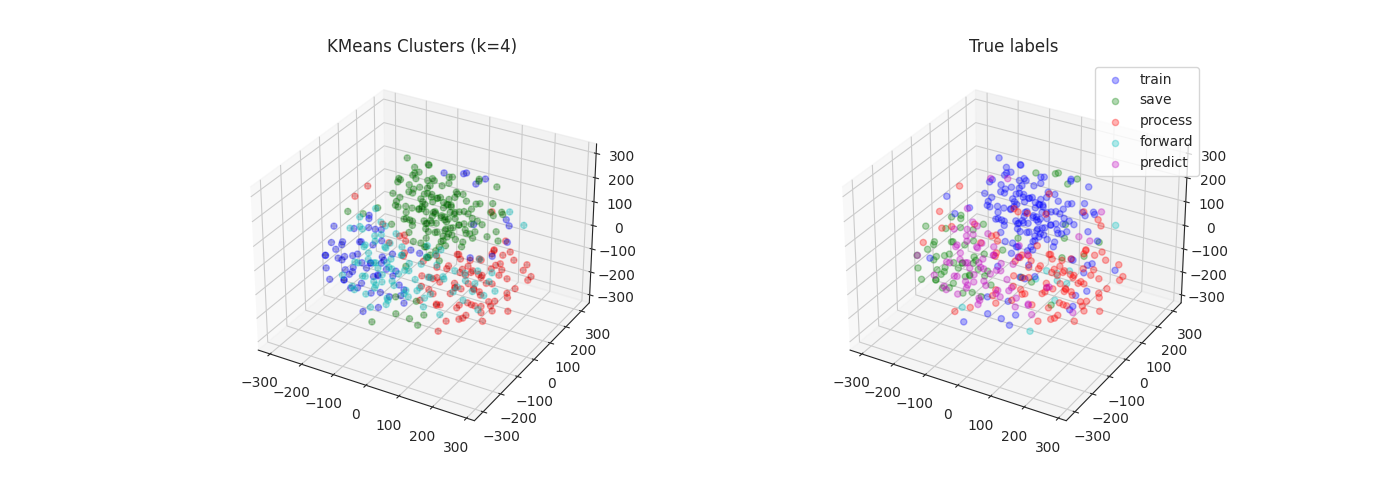

<IPython.core.display.Javascript object>


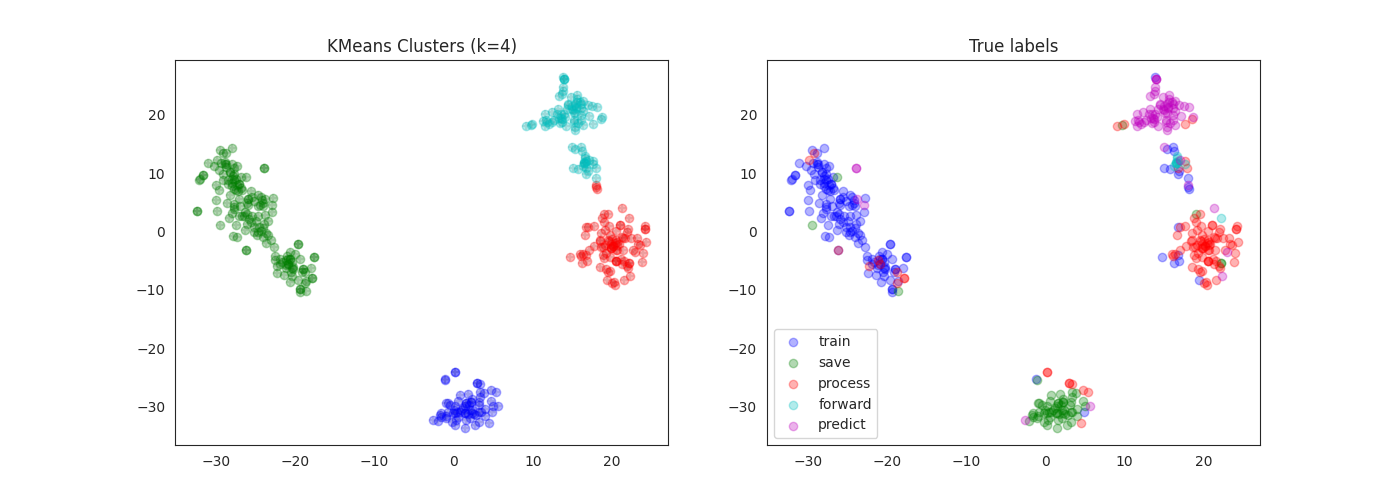

In [23]:
# Apply K-means
search_params = {'n_clusters': np.arange(2,11)}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=KMeans(random_state=0), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=features, y=None)

max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
k = search_params['n_clusters'][ind]

print(f"Best validation score {max_silhouette_score:.3f} achieved with {k} clusters")
kmeans_estimator = KMeans(n_clusters=k, random_state=0)
kmeans_name = kmeans_estimator.__class__.__name__

kmeans = kmeans_estimator.fit(features)
kmeans_metrics = calculate_metrics(kmeans_estimator, df, features, kmeans.labels_, verbose=True)

estimators[f"{kmeans_name}"] = {'estimator': kmeans_estimator, 'score':  max_silhouette_score }
estimator_metrics[f"{kmeans_name}"] = {'Estimator': kmeans_name, 'Dunn Index': kmeans_metrics['dunn_index'], 'Silhouette Score': kmeans_metrics['silhouette_score'], 'Adjusted Rand Index': kmeans_metrics['adjusted_rand_score']}

plot_clusters_3d(kmeans, df, features, kmeans.labels_)
plot_clusters_2d(kmeans, df, features, kmeans.labels_)

## Density-Based Clustering using OPTICS

Best validation score -0.015 achieved with {'min_samples': 5, 'xi': 0.2}
Number of clusters: 9
Homogeneity: 0.031
Completeness: 0.039
V-measure: 0.035
Adjusted Rand Index: -0.000
Adjusted Mutual Information: 0.002
Jaccard Coefficients: 0.012
Dunn Index: 0.0
Silhouette Coefficient: -0.317


<IPython.core.display.Javascript object>


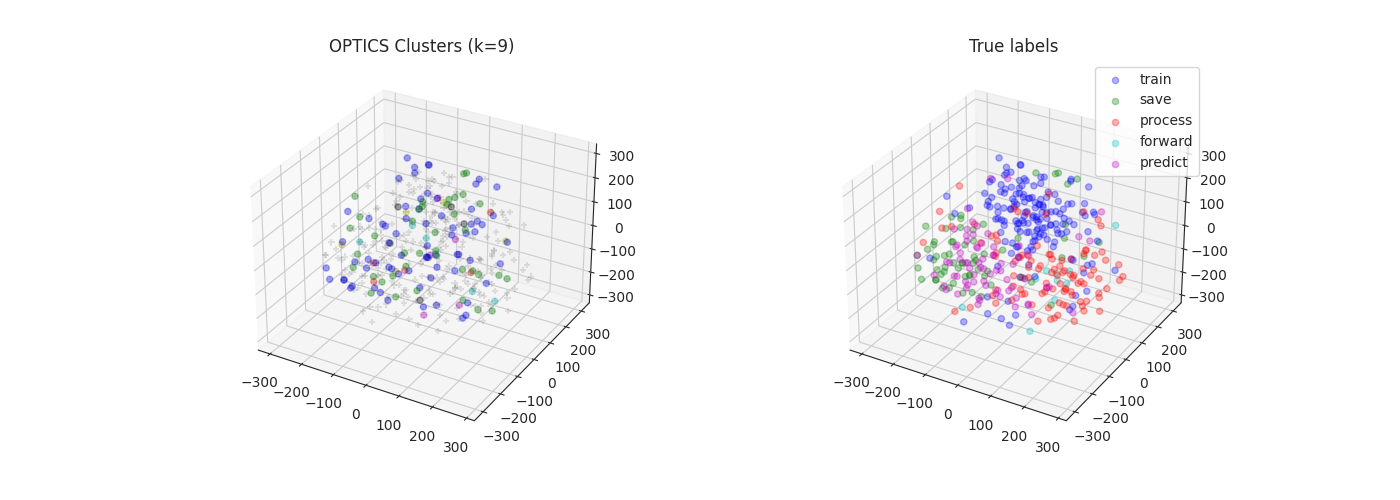

<IPython.core.display.Javascript object>


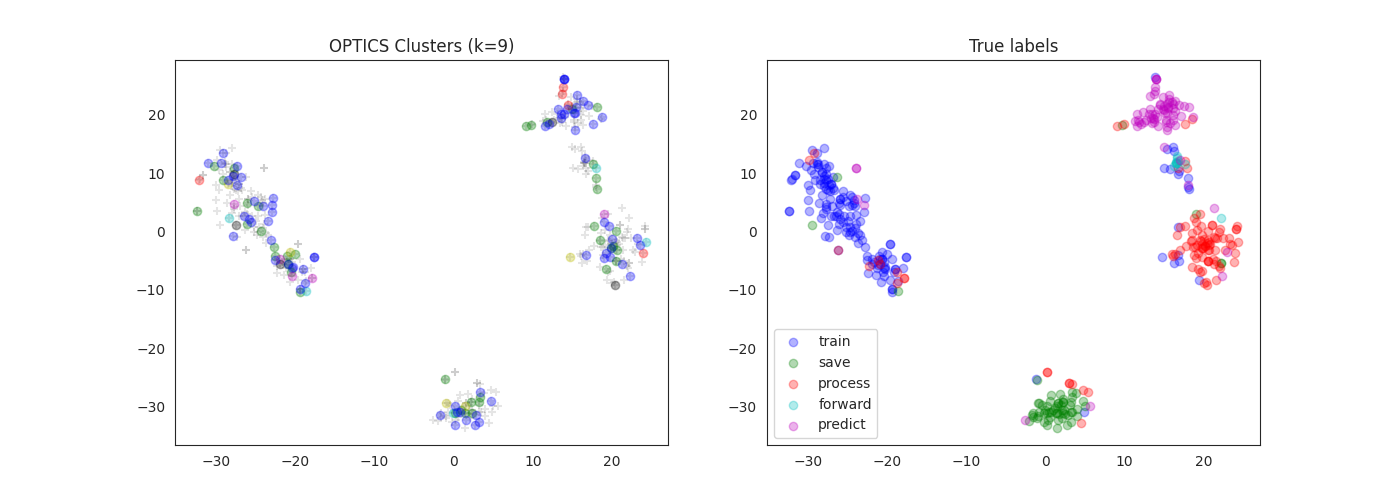

In [24]:
search_params = {'xi': np.linspace(0,1,11), 'min_samples': [2,5,10,20,30]}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=OPTICS(cluster_method='xi'), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=features, y=None)

# Get best configuration
max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
best_params = res.cv_results_['params'][ind]
k = best_params['min_samples']
# metric = best_params['metric']

# Visualize best clusters
print(f"Best validation score {max_silhouette_score:.3f} achieved with {res.cv_results_['params'][ind]}")
optics_estimator = OPTICS(cluster_method='xi', min_samples=k)
optics_name = optics_estimator.__class__.__name__

optics_clusters = optics_estimator.fit(features)
optics_metrics = calculate_metrics(optics_estimator, df, features, optics_clusters.labels_[optics_clusters.ordering_], verbose=True)

estimators[f"{optics_name}"] = {'estimator': optics_estimator, 'score':  max_silhouette_score}
estimator_metrics[f"{optics_name}"] = {'Estimator': optics_name, 'Silhouette Score': optics_metrics['silhouette_score'], 'Dunn Index': optics_metrics['dunn_index'], 'Adjusted Rand Index': optics_metrics['adjusted_rand_score']}

plot_clusters_3d(optics_clusters, df, features, optics_clusters.labels_[optics_clusters.ordering_])
plot_clusters_2d(optics_clusters, df, features, optics_clusters.labels_[optics_clusters.ordering_])

## Agglomerative Clustering (Hierarchical)

Best validation score 0.767 achieved with {'linkage': 'average', 'n_clusters': 4}
Number of clusters: 4
Homogeneity: 0.572
Completeness: 0.600
V-measure: 0.586
Adjusted Rand Index: 0.646
Adjusted Mutual Information: 0.581
Jaccard Coefficients: 0.159
Dunn Index: 0.3029310234987606
Silhouette Coefficient: 0.767


<IPython.core.display.Javascript object>


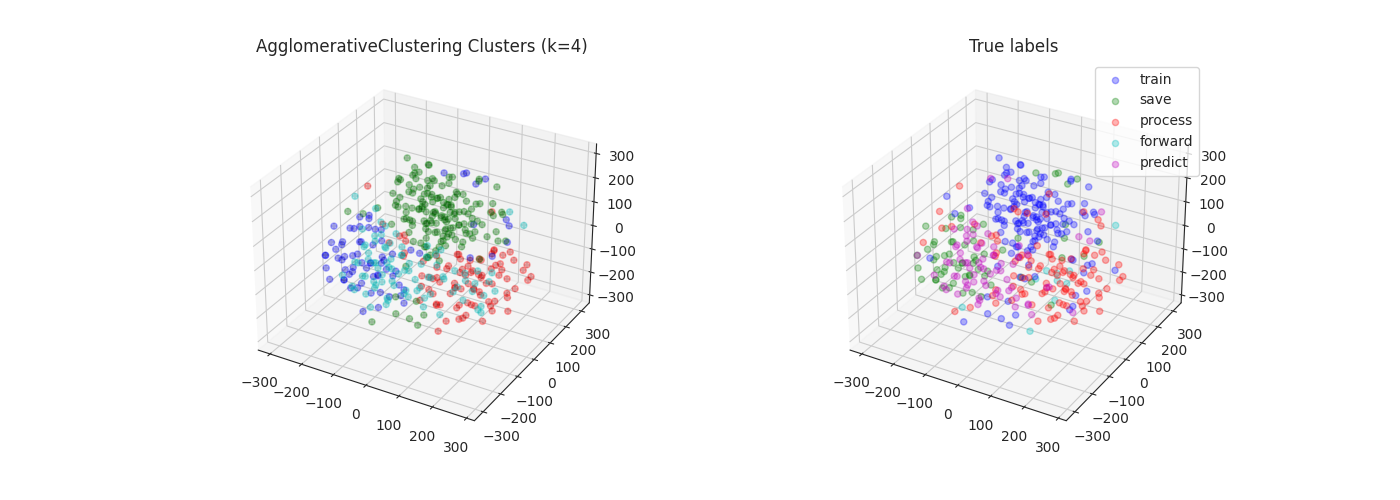

<IPython.core.display.Javascript object>


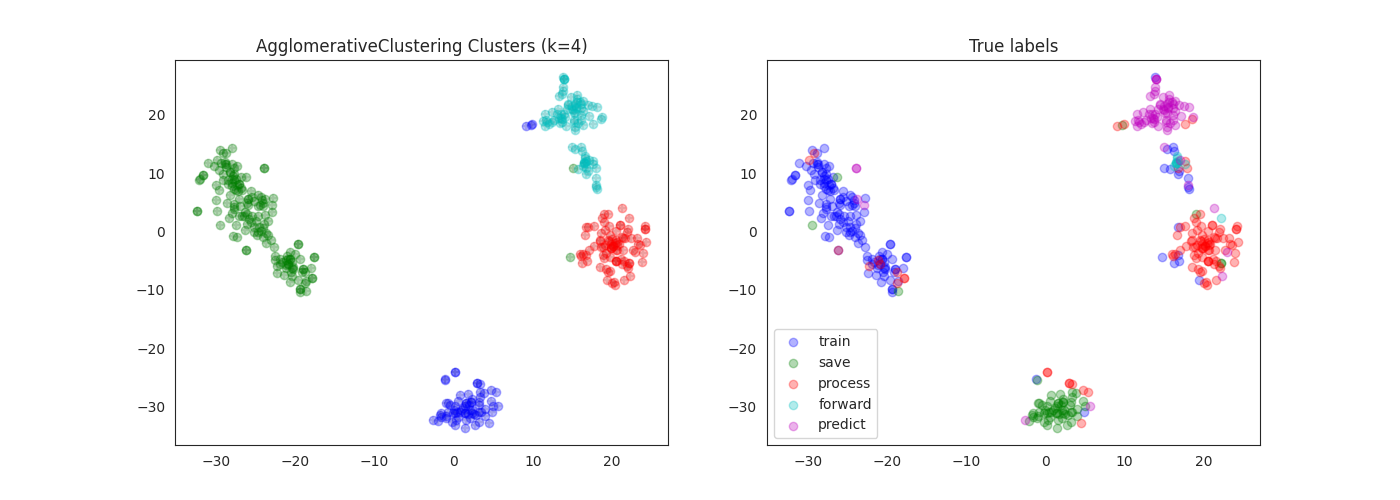

In [25]:
search_params = {'n_clusters':  np.arange(2,11), 'linkage': ['ward', 'complete', 'average', 'single']}
# search_params = {'n_clusters': np.arange(2,11), 'linkage': ['complete', 'average', 'single'], 'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']}

cv = [(slice(None), slice(None))] # Disable cv, only want grid search
gs = GridSearchCV(estimator=AgglomerativeClustering(linkage='ward'), param_grid=search_params, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)

res = gs.fit(X=features, y=None)

# Get best configuration
max_silhouette_score = np.max(res.cv_results_['mean_test_score'])
ind = np.argmax(res.cv_results_['mean_test_score'])
best_params = res.cv_results_['params'][ind]
k = best_params['n_clusters']
linkage = best_params['linkage']

# Visualize best clusters
print(f"Best validation score {max_silhouette_score:.3f} achieved with {res.cv_results_['params'][ind]}")
agglomerative_estimator = AgglomerativeClustering(n_clusters=k, linkage=linkage)
agglomerative_name = agglomerative_estimator.__class__.__name__

agglomerative_clusters = agglomerative_estimator.fit(features)
agglomerative_metrics = calculate_metrics(agglomerative_clusters, df, features, agglomerative_clusters.labels_, verbose=True)

estimators[f"{agglomerative_name}"] = {'estimator': agglomerative_estimator, 'score':  max_silhouette_score}
estimator_metrics[f"{agglomerative_name}"] = {'Estimator': agglomerative_name, 'Dunn Index': agglomerative_metrics['dunn_index'], 'Silhouette Score': agglomerative_metrics['silhouette_score'], 'Adjusted Rand Index': agglomerative_metrics['adjusted_rand_score']}

plot_clusters_3d(agglomerative_clusters, df, features, agglomerative_clusters.labels_)
plot_clusters_2d(agglomerative_clusters, df, features, agglomerative_clusters.labels_)

## Select best estimator

In [26]:
scores = [val['score'] for val in estimators.values()]
ind = np.argmax(scores)
best_estimator = list(estimators.values())[ind]['estimator']

In [27]:
print(f"Best cluster method: {get_estimator_name(best_estimator)}\nParams:\n{best_estimator.__dict__}")

Best cluster method: KMeans
Params:
{'n_clusters': 4, 'init': 'k-means++', 'max_iter': 300, 'tol': 0.0001, 'precompute_distances': 'auto', 'n_init': 10, 'verbose': 0, 'random_state': 0, 'copy_x': True, 'n_jobs': None, 'algorithm': 'auto', 'cluster_centers_': array([[ 5.01068254e-01,  1.60112187e+00,  8.14553989e-02, ...,
         1.58348102e+00, -1.81724554e-01, -4.71008053e-01],
       [-2.72517226e-01, -8.42182501e-01,  3.65752044e-01, ...,
        -6.63318318e-01, -2.99010467e-01, -8.07823265e-01],
       [ 1.90277771e-01,  8.25651732e-01, -2.83099759e-01, ...,
        -7.68544122e-02,  3.28712393e-01,  1.71221810e+00],
       [-4.04260984e-01, -2.98416337e-01,  3.60212302e-01, ...,
        -1.00714947e-01,  4.31296667e-04, -1.78387506e-01]]), 'labels_': array([3, 1, 2, 1, 3, 2, 3, 1, 0, 3, 0, 1, 0, 2, 0, 1, 1, 1, 0, 3, 1, 2,
       1, 3, 3, 3, 2, 1, 2, 0, 3, 0, 1, 1, 0, 1, 3, 2, 1, 1, 0, 2, 1, 2,
       3, 1, 1, 2, 2, 0, 1, 1, 1, 2, 2, 1, 1, 3, 1, 3, 0, 1, 0, 2, 2, 0,
       2, 2, 

In [28]:
# Write configs of the best estimators from each category to file
with open(f"{LOG_DIR}/cubert_estimators_config.txt", "w") as writer:
    for conf, score in [(val['estimator'].__dict__,val['score']) for val in estimators.values()]:
        writer.write(f"Estimator config:\n{conf}\nSilhouette Score: {score}\n\n")

In [29]:
# Write the chosen cluster metrics for the best models to table
latex_table = pd.DataFrame([d for d in estimator_metrics.values()], columns=['Estimator','Dunn Index', 'Silhouette Score', 'Adjusted Rand Index']).to_latex(index=False, float_format="%.3f").replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline')
with open(f"{LOG_DIR}/tables/cubert_clustering_metrics_table.tex", "w") as writer:
    writer.write(latex_table)

# Write all cluster metrics to table
latex_table = pd.DataFrame([d for d in [kmeans_metrics, optics_metrics, agglomerative_metrics]]).to_latex(index=False, float_format="%.3f").replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline')
with open(f"{LOG_DIR}/tables/cubert_clustering_metrics_all_table.tex", "w") as writer:
    writer.write(latex_table)